In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

### load data

In [2]:
dataset = pd.read_csv('Finaldata_with_Fourier.csv', parse_dates=['Date'])
news = pd.read_csv("News.csv", parse_dates=["Date"])

### process data
replace the data where the values are 0 with N/A and then save all that data in dataset.csv file

In [3]:
# Replace 0 by NA
dataset.replace(0, np.nan, inplace=True)
dataset.to_csv("dataset.csv", index=False)


In [4]:
# Add News data
dataset["News"] = news["Score"]


In [5]:
# Check NA and fill them
dataset.isnull().sum()
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()
print(dataset.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ ', 'NYSE ',
       'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000',
       'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon',
       'Google', 'Microsoft', 'MA7', 'MA21', 'MACD', '20SD', 'upper_band',
       'lower_band', 'EMA', 'logmomentum', 'absolute of 3 comp',
       'angle of 3 comp', 'absolute of 6 comp', 'angle of 6 comp',
       'absolute of 9 comp', 'angle of 9 comp', 'News'],
      dtype='object')


In [6]:
# Set the date to datetime data
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')


In [7]:
 #Get features and target
X_value = pd.DataFrame(dataset.iloc[:, :])
y_value = pd.DataFrame(dataset.iloc[:, 3])

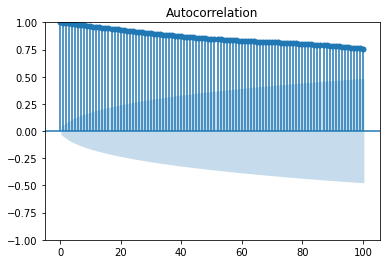

In [8]:
# Autocorrelation Check
sm.graphics.tsa.plot_acf(y_value.squeeze(), lags=100)
plt.show()


### Normalization:
improves the performance and accuracy of machine learning models using various techniques and algorithms.

In [9]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))


In [10]:
# Reshape the data
'''Set the data input steps and output steps, 
    we use 30 days data to predict 1 day price here, 
    reshape it to (None, input_step, number of features) used for LSTM input'''
n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

### train & test

In [11]:
# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)


In [12]:
# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index


In [13]:
# Split train/test dataset
def split_train_test(data):
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test


In [16]:
# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, n_steps_in, n_steps_out)
# %% --------------------------------------- Save dataset -----------------------------------------------------------------
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("yc_train.npy", yc_train)
np.save("yc_test.npy", yc_test)
np.save('index_train.npy', index_train)
np.save('index_test.npy', index_test)
#np.save("res_train.npy",index)
#Footer

X shape:  (2494, 3, 36)
y shape:  (2494, 1)
X_train shape:  (1746, 3, 36)
y_train shape:  (1746, 1)
y_c_train shape:  (1746, 3, 1)
X_test shape:  (748, 3, 36)
y_test shape:  (748, 1)
y_c_test shape:  (748, 3, 1)
index_train shape: (1746,)
index_test shape: (748,)
